# Jupyter Pipeline for Mouse Simulation

### Outputs Time Series Matrix, Parameters, FCM and SCM vs FCM Spearson Correlation

In [1]:
# First Import the packages.
from tvb.simulator.lab import *
LOG = get_logger('demo')
from tvb.simulator.plot.tools import *
import numpy as np
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
from scipy import stats
#matplotlib.style.use('ggplot')
import inspect
import os
import csv 
import time

INFO  log level set to INFO


## Main adjustments below, can hopefully get away with only changing cell below!

In [2]:
# Set up input Parameters for entire pipeline as dictionary elements here:

# Empty dict
ParamsDict = { }

# Name of import file/zip - Which contains connectivity data.
ParamsDict["name"] = "MouseCortex"

# Monitors or not?  (Aka BOLD or not?)
ParamsDict["BOLD"] = True

# Snip is the the number of elements you wish to snip at the start to remove the initial condition effects.
ParamsDict["Snip"] = 10
# Note, if BOLD = False, Snip gets multiplied by 1000. 
if ParamsDict["BOLD"] == False:
    ParamsDict["Snip"] = 1000 * ParamsDict["Snip"]

# Set the Random State/Seed for the Stochastic Integrator:
ParamsDict["RandState"] = 118

# Set Simulation Length:
ParamsDict["Simul_length"] = 1.2e6

# Set Linear Coupling Constant:
ParamsDict["G"] = 0.096

# Set integrator time step dt.
ParamsDict["dt"] = 0.1

# Set Additive Noise strength
ParamsDict["noise"] = 0.000013

# Set Wilson Cowan Model Parameters
ParamsDict["MODEL_c_ee"] = 12
ParamsDict["MODEL_c_ei"] = 15
ParamsDict["MODEL_c_ie"] = 10
ParamsDict["MODEL_c_ii"] = 12

# Define the model. 
ParamsDict["MODEL"] = models.WilsonCowan(c_ee=ParamsDict["MODEL_c_ee"],c_ei=ParamsDict["MODEL_c_ei"],c_ie=ParamsDict["MODEL_c_ie"] ,c_ii=ParamsDict["MODEL_c_ii"]) 

# models.WilsonCowan(c_ee=np.array([0,11,0,0,0]),c_ei=np.array([0,10,0,0,0]),c_ie=np.array([0,10,0,0,0]),c_ii=np.array([0,11,0,0,0]),b_e=2.5,b_i=3) 
# models.WilsonCowan(c_ee=np.arange(11,19,2),c_ei=10,c_ie=10,c_ii=1,b_e=2.5,b_i=3) 
# models.WilsonCowan(c_ee=np.arange(11,16,1)) 
# models.WilsonCowan()

# models.ReducedWongWang(w=1.0, I_o=0.3)
# models.ReducedWongWang(w=1.0, I_o=0.3)

#models.WilsonCowan(r_e=1.0,r_i=1.0,b_e=4.0,b_i=4.0,alpha_e=1.0,alpha_i=2.0,P=0)

In [3]:
# Load the connectivity data from a zip file. 
con = connectivity.Connectivity.from_file(os.getcwd() +"\\Connectomes\\" + ParamsDict["name"] + ".zip")

# Mouse Allen Connectivity (from within TVB)
# con = connectivity.Connectivity.from_file("../mouse/allen_2mm/Connectivity.h5")

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


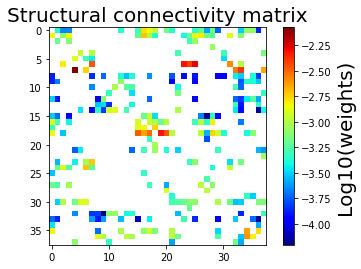

In [4]:
# Visualize the structural connectivity matrix
plt.subplots()
cs=plt.imshow(np.log10(con.weights), cmap='jet', aspect='equal', interpolation='none')
plt.title('Structural connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Log10(weights)', fontsize=20)
#plt.yticks([0,1,2,3])

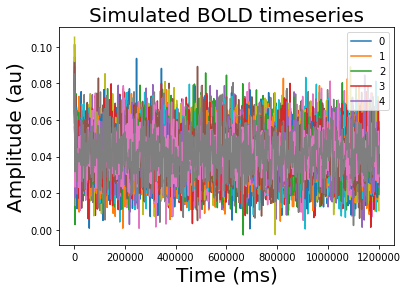

In [5]:
# Set the parameter of the resting state simulation

if ParamsDict["BOLD"] == True:
    sim = simulator.Simulator(model=ParamsDict["MODEL"],
                            connectivity=con,
                            coupling=coupling.Linear(a=ParamsDict["G"]),
                            integrator=integrators.EulerStochastic(dt=ParamsDict["dt"],noise=noise.Additive(nsig=ParamsDict["noise"],
                                        random_stream=np.random.RandomState(ParamsDict["RandState"]))),
                            monitors=(monitors.Bold(period=2e3),
                                      monitors.TemporalAverage(period=1e3)),
                            simulation_length=ParamsDict["Simul_length"],
                            #initial_conditions=[1.8,1.8,1.8,1.8,1.8]
                            ).configure()
    # Run the resting state simulation
    (bold_time, bold_data), _ = sim.run()

    # Display the simulated bold timeseries
    plt.subplots()
    plt.plot(bold_time,bold_data[:,0,:,0])
    plt.xlabel('Time (ms)', fontsize=20)
    plt.ylabel('Amplitude (au)', fontsize=20)
    plt.title('Simulated BOLD timeseries', fontsize=20)
    plt.legend(('0','1','2','3','4'))

# No Monitors 
else:

  sim = simulator.Simulator(model=ParamsDict["MODEL"],
                          connectivity=con,
                          coupling=coupling.Linear(a=ParamsDict["G"]),
                          integrator=integrators.EulerStochastic(dt=ParamsDict["dt"],noise=noise.Additive(nsig=ParamsDict["noise"],
                                        random_stream=np.random.RandomState(ParamsDict["RandState"]))),
                          simulation_length=ParamsDict["Simul_length"]).configure()
  # Run the resting state simulation
  awer = sim.run()
  bold_time = awer[0][0]
  bold_data = awer[0][1]

  # Display the simulated non-bold timeseries
# Display the simulated non-bold timeseries
  plt.subplots()
  plt.plot(bold_time,bold_data[:,0,:,0])
  plt.xlabel('Time (ms)', fontsize=20)
  plt.ylabel('Amplitude (au)', fontsize=20)
  plt.title('Simulated non-BOLD timeseries', fontsize=20)
  plt.legend(('0','1','2','3','4'))

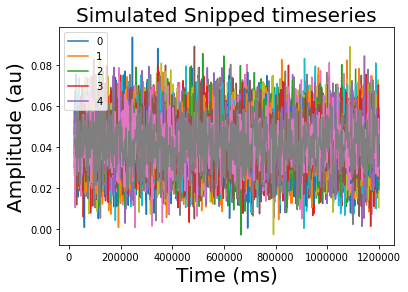

In [6]:
# Display the simulated snipped timeseries

# Got lazy
Snip = ParamsDict["Snip"]
plt.subplots()
plt.plot(bold_time[Snip:],bold_data[Snip:,0,:,0])
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('Simulated Snipped timeseries', fontsize=20)
plt.legend(('0','1','2','3','4'))

In [7]:
# Functional Connectivity Matrix. 

# We note that this is a static analysis.  More advanced version would be a DYnamic version with windowing.

# Convert Simulation output into a form usable by Numpy.
TSeriesMatrix = np.empty((bold_data.shape[2], bold_data.shape[0]-Snip))
#Matrix = []

for i in range(bold_data.shape[2]):
    TSeriesMatrix[i] = bold_data[Snip:,0,i].flatten()

# Functional Conenctivity MAtrix = Pearson Correlation.

FCM = np.corrcoef(TSeriesMatrix)
FCM

array([[ 1.        ,  0.00244687,  0.11216903, ...,  0.04340211,
         0.03780899,  0.02979552],
       [ 0.00244687,  1.        , -0.07018573, ...,  0.05482576,
         0.07546027, -0.02412869],
       [ 0.11216903, -0.07018573,  1.        , ...,  0.0778494 ,
        -0.03025079,  0.00502835],
       ...,
       [ 0.04340211,  0.05482576,  0.0778494 , ...,  1.        ,
         0.08252596, -0.02212745],
       [ 0.03780899,  0.07546027, -0.03025079, ...,  0.08252596,
         1.        , -0.00172813],
       [ 0.02979552, -0.02412869,  0.00502835, ..., -0.02212745,
        -0.00172813,  1.        ]])

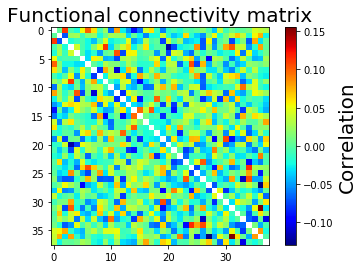

In [8]:
# Plot Matrix
# Set diagonals to NaN
FCM1 = FCM
np.fill_diagonal(FCM1,np.nan)

cs=plt.imshow(FCM1, cmap='jet', aspect='equal', interpolation='none')
plt.title('Functional connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Correlation', fontsize=20)
#plt.yticks([0,1,2,3])

In [9]:
# Comparing SC Vs FC with Spearman Correlation

# Grab Upper triangles
FCM_Upper = FCM[np.triu_indices(FCM.shape[0], k = 1)]
SCM_Upper = con.weights[np.triu_indices(con.weights.shape[0], k = 1)]

# Spearman Correlation
SCorr = stats.spearmanr(a=FCM_Upper,b=SCM_Upper)
print(SCorr)

SpearmanrResult(correlation=-0.05187111667607053, pvalue=0.16950505518401238)


Text(0.05,0.95,u'SpearmanrResult(correlation=-0.05187111667607053, pvalue=0.16950505518401238)')

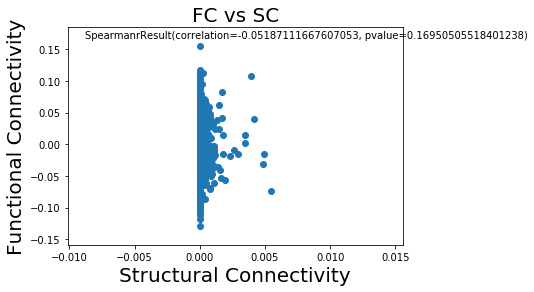

In [10]:
plt.scatter(SCM_Upper,FCM_Upper)
plt.xlabel('Structural Connectivity', fontsize=20)
plt.ylabel('Functional Connectivity', fontsize=20)
plt.title('FC vs SC', fontsize=20)
plt.annotate(SCorr, xy=(0.05, 0.95), xycoords='axes fraction')

In [11]:
# Export the simulation
time_now = time.strftime("%Y%m%d-%H%M%S")

# Params Dictionary - Note how we sort the dictionary.
with open("do-not-track\\" + ParamsDict["name"] + "_Params_" + time_now + "_.csv", "w") as outfile:
    writer = csv.writer(outfile)
    for key, val in sorted(ParamsDict.items()):
        writer.writerow([key, val])
    
# Create Time Series and save. 
TSeries = np.concatenate((bold_time[Snip:].reshape(1,len(bold_time[Snip:])),TSeriesMatrix))
np.savetxt("do-not-track\\" + ParamsDict["name"] + "_Tseries_" + time_now + "_.csv", TSeries, delimiter="\t")
np.savetxt("do-not-track\\" + ParamsDict["name"]  + "_FCM_" + time_now + "_.csv", FCM, delimiter = "\t")
np.savetxt("do-not-track\\" + ParamsDict["name"]  + "_Scorr_" +  time_now + "_.csv", SCorr, delimiter = "\t")  